In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernel_opt import plot_kernel_loss, plot_kernel_loss_2d
from myopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel
from myopt.bayesian_optimization import bo_plot_exploration, bo_maximize, Integer, Float
from myopt.bayesian_optimization import plot_2d_optim_result, bo_maximize_parallel, bo_plot_exploration_parallel
from myopt.acquisition_functions import expected_improvement, probability_of_improvement
from myopt.bayesian_optimization import propose_location
from myopt.opt_functions import get_opt_test_functions
from myopt.plot import plot_gp

import GPy

## Broken kernel


In [234]:
noise = 0.1

params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])
X_train = np.array([2,2.01,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5])
# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01)

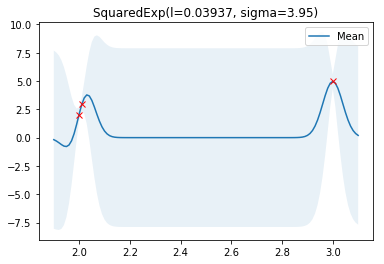

In [235]:
GaussianProcess(noise=noise, kernel=SquaredExp()).fit(X_train, y_train)\
    .optimize_kernel().posterior(X).plot_posterior(figure=False, num_samples=0)

# Sklearn

0.0393686526711134 3.948456038794823


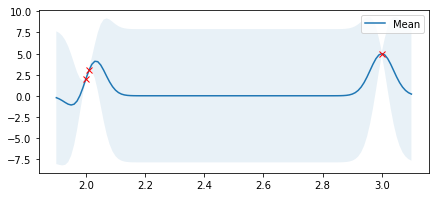

In [236]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

gpr.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

mu_s, cov_s = gpr.predict(X.reshape(-1, 1), return_cov=True)

l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
print(l, sigma_f)

plot_gp(mu_s.reshape(-1), cov_s, X, X_train, y_train, num_samples=0)

# GPy

0.039368413056503064 3.948475675787181


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f3aa5e46470>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f3aa5e46898>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f3aa60fd400>]}

 /home/darth/.venv/tf-gpu/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


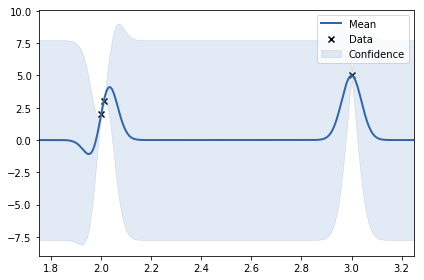

In [237]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1), rbf)

gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

gpr.optimize()

l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])
print(l, sigma_f)

gpr.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f3aa6a7c5c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f3aa6a7c208>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f3aa6148780>]}

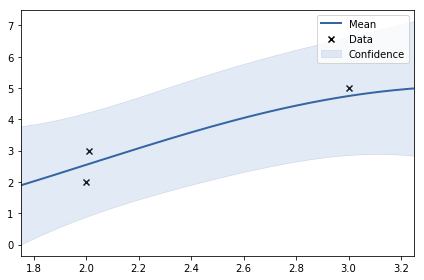

In [238]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
# kernel = GPy.kern.Matern52(input_dim=1, variance=1., lengthscale=1.)

m = GPy.models.GPRegression(X_train.reshape(-1,1),y_train.reshape(-1, 1),kernel)
m.optimize(messages=True)
m.plot()

In [239]:
rbf.K(X_train.reshape(-1, 1), X_train.reshape(-1, 1))

array([[1.55904602e+001, 1.50955269e+001, 1.21980344e-139],
       [1.50955269e+001, 1.55904602e+001, 7.48877146e-137],
       [1.21980344e-139, 7.48877146e-137, 1.55904602e+001]])

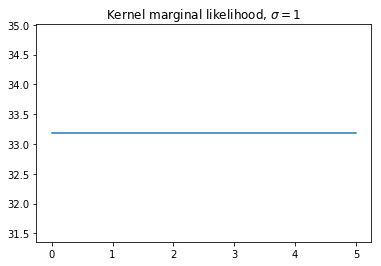

In [253]:
class GPyWrapper:
    def __init__(self):
        self.params = None
        
    def set_params(self, params):
        self.params = params
        return self
        
    def __call__(self, a, b):
        return GPy.kern.RBF(input_dim=1, variance=1., lengthscale=params[0]).K(a.reshape(-1, 1), b.reshape(-1, 1))

plot_kernel_loss(GPyWrapper(), X_train, y_train)

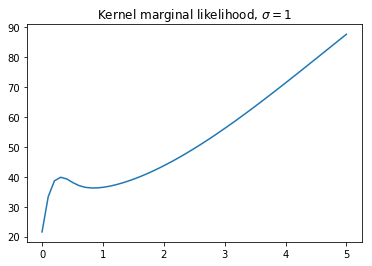

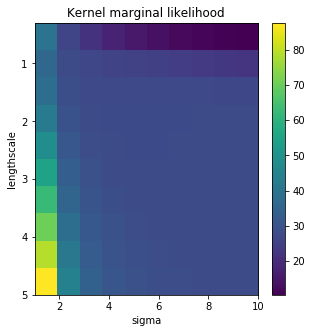

In [251]:
kernel = SquaredExp(sigma=0.001)
plot_kernel_loss(kernel, X_train, y_train)
plot_kernel_loss_2d(kernel, X_train, y_train)

# Big data

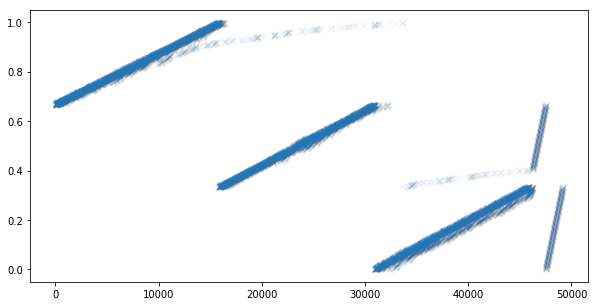

In [2]:
values = np.genfromtxt("data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [13]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

In [14]:
def fit_with_scale(X, y, scale):
    y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
    X = np.array(list(range(len(y)))) / scale

    gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
    gp.plot_posterior(num_samples=0)


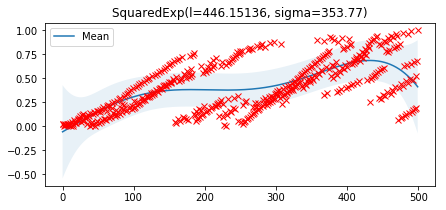

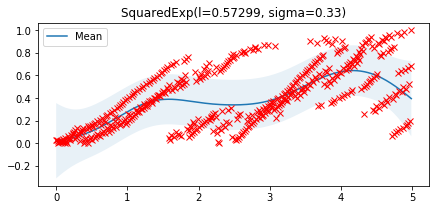

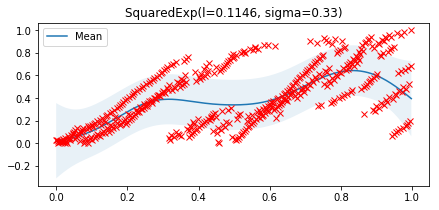

In [17]:
def foo():
    for i in [1,100, 500]:
        fit_with_scale(X, y, i)
        plt.show()
        
foo()

# TODO Gaussian likelihood for a given covariance

# TODO Gaussian likelihood for a given covariance

In [176]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

AttributeError: 'numpy.ndarray' object has no attribute 'set_params'

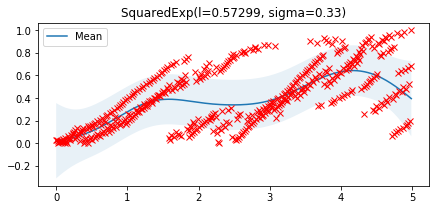

In [5]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

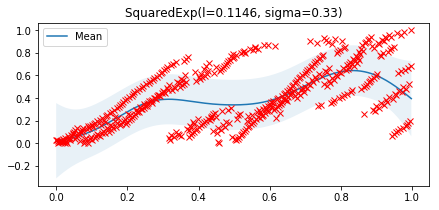

In [6]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

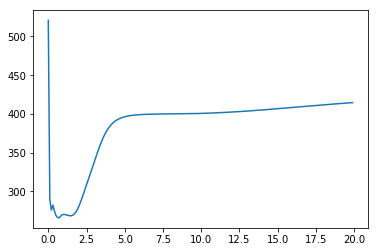

In [7]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

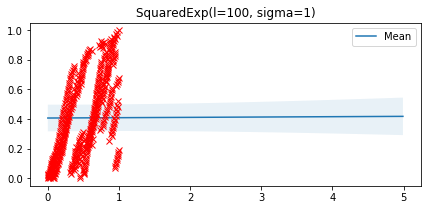

In [8]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)